# A (simplified) TrueSkill

## Backstory
One of the cool things done with Bayesian modelling was the construction of the [TrueSkill system](https://www.microsoft.com/en-us/research/publication/trueskilltm-a-bayesian-skill-rating-system/) for Microsoft Xbox online gaming platform by Ralf Herbrich and Tom Minka from Microsoft Research.  The objective of TrueSkill is simple: as quickly as possible match a player with players of similar skill with whom it will be most fun to play. Handle team play.  To reach this objective, the TS system must estimate each players quality as fast as possible.  This is done in real-time using expectation propagation (not in scope of this tutorial), and the [paper](https://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) shows the results compared to e.g. chess ELO - and they're impressive.

**Note**: if you read the paper, note that it builds a massive PGM (probabilistic graphical model) that reflects all players and does approaximate inference via message passing - this is a variational approach for probabilistic graphical models. This will be the subject of further preparations and workshops.  However the paper discusses how the total probability distribution is built as a product of **factors** which is the subject of this exercise.  Reading the paper should give you a view of where we want to go in the (near) future.

## An example from the TrueSkill paper

Let us model the example from the TrueSkill paper, which shows an update after one game played.  Instead of using message passing, we will build the model using PyMC3.

The TrueSkill approach models team play as follows:
- Players $i \in I=\{1, .., n\}$ are partitioned into teams $A_i \subset I$, which are (of course) pairwise disjoint.
- Each player has a *skill* $s_i \sim {\cal N}(\mu_i, \sigma_i^2)$
- The **skill** results in a given **performance** during a game $p_i \sim {\cal N}(s_i, \beta^2)$
- The total performance of team $j$ is $t_j = \sum_{i \in A_j} s_i$.
- The game outcome is controlled by the difference in team performance $d = t_i-t_j$ depending on which teams we are comparing.
- The paper posits a strategy of updating parameters depending on win/tie/loss which happens depending on differences in the team performance differences as compared to a parameter $\epsilon$.  if $t_i-t_j > \epsilon$ the model predicts a win of team $t_i$, the converse is true and if $|t_i-t_j| \leq \epsilon$, then the model predicts a draw. Anything else is a surprise outcome.

Instead of the actual functions used in TrueSkill, we propose a simplified strategy that is easier to implement:
- if $t_i - t_j > \epsilon$, then $t_i$ wins with probability 90%, there is a draw with 9% probability and with 1% probability, team $i$ loses
- if $|t_i - t_j| <= \epsilon$, then $t_i$ and $t_j$ draw with 90% and win/lose situations (i.e. the complement) constitute 10%

In our example, let us fix $I=\{1,2,3,4\}$ with three teams $A_1 =\{1\}, A_2=\{2,3\}, A_3=\{4\}$.  Let us assume that after the game ends, team $A_1$ has first place while teams $A_2$ and $A_3$ tied for second place.

Let us assume that the prior for the skill of each player is ${\cal N}(25, 25/3)$ and that the draw margin is $\epsilon=3$.  Let us assume that $\beta=5$.

The model can then be constructed for example as follows

In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

with pm.Model() as trueskill:
    
    mu0, sigma0 = 25., 25./3
    beta = 5.
    epsilon = 3
    
    s1 = pm.Normal('s1', mu0, sd=sigma0/10)
    s2 = pm.Normal('s2', mu0, sd=sigma0)
    s3 = pm.Normal('s3', mu0, sd=sigma0)
    s4 = pm.Normal('s4', mu0, sd=sigma0)
    
    p1 = pm.Normal('p1', s1, sd=beta)
    p2 = pm.Normal('p2', s2, sd=beta)
    p3 = pm.Normal('p3', s3, sd=beta)
    p4 = pm.Normal('p4', s4, sd=beta)
        
    # add 'observed likelihood' factors here, note that function should return logp
    pm.Potential('t1_win_against_t2', tt.switch(pm.math.ge(p1 - p2 - p3, epsilon), np.log(0.9),
                                             tt.switch(pm.math.ge(p1 - p2 - p3, epsilon), np.log(0.01), np.log(0.09))))

    pm.Potential('t2_draw_t3', tt.switch(pm.math.le(pm.math.abs_(p2+p3 - p4), epsilon), np.log(0.9), np.log(0.1)))


/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let us examine the MAP point estimate to check what happens to the individual player skills after the four games have been observed.

In [2]:
with trueskill:
    model_map = pm.find_MAP(method='Powell')
    
model_map

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/scipy/optimize/_minimize.py:415: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -24.678, ||grad|| = 1.1742e-08: 100%|██████████| 323/323 [00:00<00:00, 685.83it/s]


{'p1': array(25.),
 'p2': array(25.),
 'p3': array(25.00000021),
 'p4': array(25.),
 's1': array(25.),
 's2': array(25.),
 's3': array(25.),
 's4': array(25.)}

What happened? And now let us look at the posterior distribution.  First we use the default (NUTS) sample in PyMC3.

In [7]:
with trueskill:
    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 3000/3000 [07:24<00:00,  6.75it/s]/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [ ]:
_ = pm.traceplot(trace)

In [3]:
with trueskill:
    trace = pm.sample(draws=10000, tune=1000, step=pm.Metropolis())

100%|██████████| 30000/30000 [00:41<00:00, 715.83it/s]


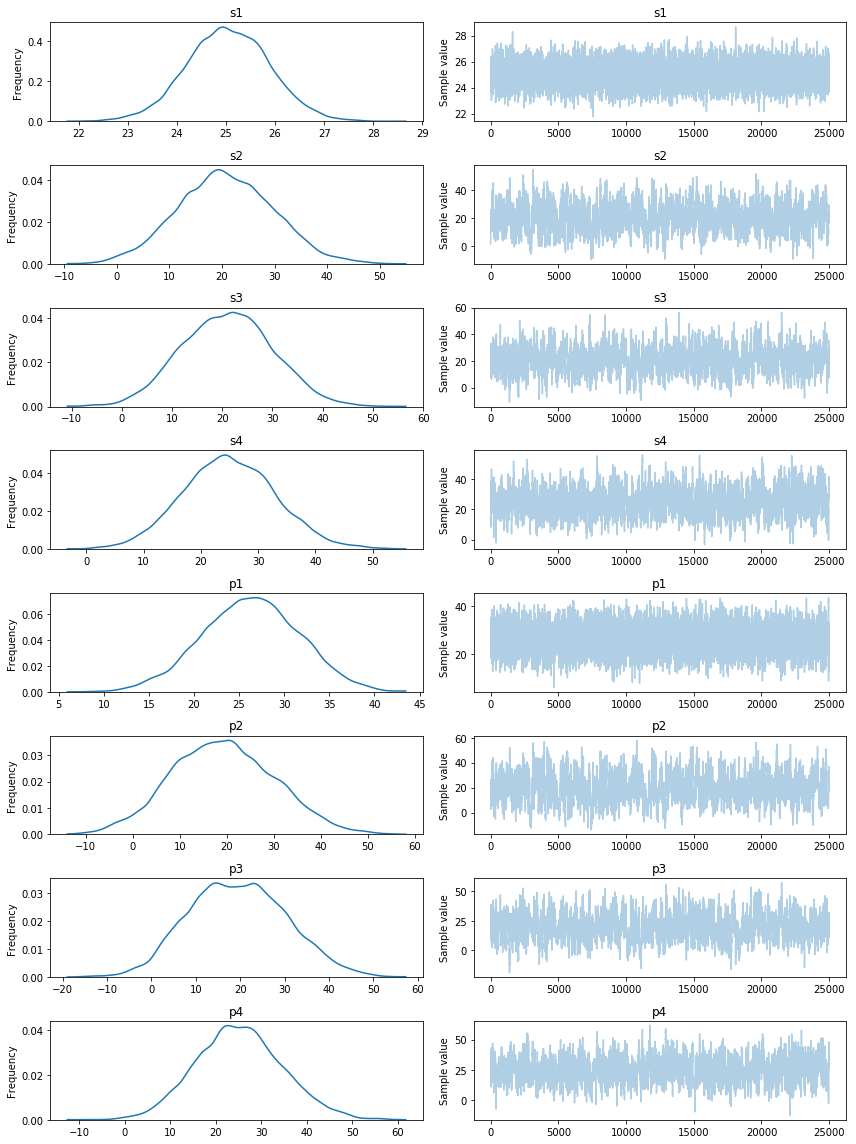

In [4]:
_ = pm.traceplot(trace)

In [5]:
pm.summary(trace, varnames=['s1', 's2', 's3', 's4'])


s1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  25.030           0.832            0.012            [23.399, 26.668]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  23.399         24.470         25.024         25.594         26.670


s2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  20.744           9.044            0.354            [2.845, 38.244]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.137          14.448         20.533         26.802         38.620


s3:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------

Above, we have inferred changes to the players' skills after observing the four games.

### Questions
- How do you interpret the resulting skills? What was your expectation?
- What would happen if the prior for one of the players was tighter (smaller variance)?  This could happen if we have already seen this player playing someone else before and we thus have more information about her. MOdify the model and examine the results.
- Can you criticize the model?

## References

1. Herbrich, Minka and Graepel. [TrueSkill™: A Bayesian Skill Rating System](https://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system), NIPS 2006.